# Data Casal Montserratina

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np
from datetime import timedelta

import os

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# for EDA
from ydata_profiling import ProfileReport 

#Others
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

# Funciones

In [2]:
def grafico_zoom(df_x, df_y, title="", xaxis_title="", yaxis_title=""):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df_x,  # x-axis
        y=df_y,  # y-axis
        mode='lines',  # Connect data points with lines
        name='Line',  # Name in the legend
        connectgaps=False  # Do not connect the gaps (NaN values)
    ))

    # Layout parameters
    fig.update_layout(
        title=title,  # Title
        xaxis_title=xaxis_title,  # x-axis name
        yaxis_title=yaxis_title,  # y-axis name
        xaxis_tickangle=0,  # Set the x-axis label angle
        showlegend=False  # Do not display the legend
    )

    fig.show()

In [3]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [4]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [5]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

In [6]:
def dataframe_slicer (df, fecha_inicial, fecha_final):
    """
    Recorta el DataFrame en base a una fecha inicial y otra final.

    Parameters:
    df (DataFrame): El DataFrame original que contiene los datos.
    fecha_inicial (str): La fecha inicial en formato 'YYYY-MM-DD HH:MM:SS'.
    fecha_final (str): La fecha final en formato 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    DataFrame: Un nuevo DataFrame recortado.
    """
    # Convertir las columnas de fecha a datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filtrar el DataFrame en base a las fechas
    df_recortado = df[(df['Date'] >= fecha_inicial) & (df['Date'] <= fecha_final)]
    
    return df_recortado

# Load Data

In [7]:
ruta_data = "../data/data_casal_montserratina/"

In [8]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [9]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [10]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df.rename(columns={'TimeStamp': 'Date'}, inplace=True)
df.rename(columns={'Valor': 'Consumo'}, inplace=True)
df.rename(columns={'Període tarifari': 'Periode_tarifari'}, inplace=True)
df.rename(columns={'Tipus lectura': 'Tipus_lectura'}, inplace=True)

In [11]:
df

Date  Consumo  Periode_tarifari Tipus_lectura
0     2022-01-01 00:00:00        6                 6          Real
1     2022-01-01 01:00:00        6                 6          Real
2     2022-01-01 02:00:00        5                 6          Real
3     2022-01-01 03:00:00        7                 6          Real
4     2022-01-01 04:00:00        7                 6          Real
...                   ...      ...               ...           ...
17683 2024-05-07 19:00:00       10                 4          Real
17684 2024-05-07 20:00:00        7                 4          Real
17685 2024-05-07 21:00:00        4                 4          Real
17686 2024-05-07 22:00:00        2                 5          Real
17687 2024-05-07 23:00:00        2                 5          Real

[17688 rows x 4 columns]

# EDA

In [12]:
# # Generate the report
# profile = ProfileReport(df,title="monserratina_2022_2023", tsmode=True, sortby="Date", correlations={"auto": {"calculate": False}})

# # Save the report to .html
# # profile.to_file("monserratina_2022_2023.html")

# profile

In [13]:
# Elimino la columna "Tipo de Lectura" & "Periode Tarifari"
df = df.drop(columns=["Tipus_lectura", "Periode_tarifari"])

# Missing values

In [14]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


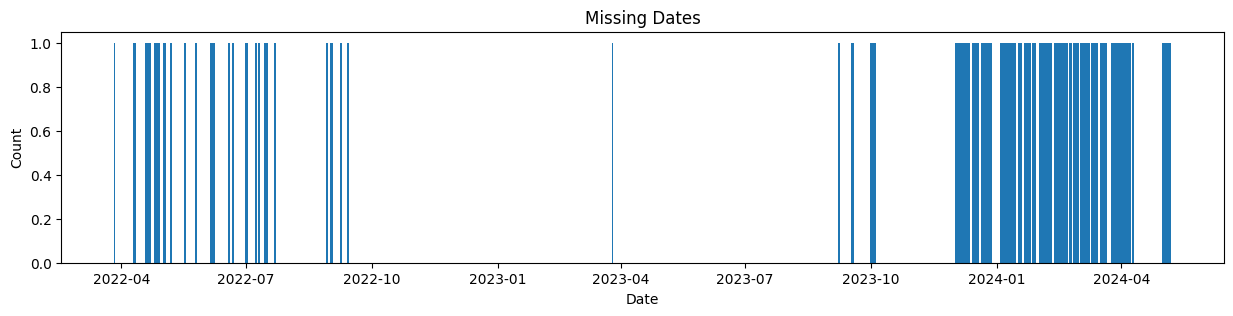

In [15]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")
# plt.xticks(rotation=0)
plt.show()

In [16]:
# un ejemplo de las fechas faltantes.

print(df[(df["Date"]>"2022-04-09 22:00:00") & (df["Date"]<"2022-04-11 01:00:00")])

# >>>>> notar que entre las 23 del 9/4 a las 00 del 11/4 no hay datos. 

                    Date  Consumo
2374 2022-04-09 23:00:00        2
2375 2022-04-11 00:00:00        2


In [17]:
grafico_zoom(df.index, df["Consumo"],
              "Consumo Eléctrico (con Huecos) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kW]")

### rellenar los huecos de Date

In [18]:
df = df.drop_duplicates(keep=False) # duplicados no hay, pero surgió un par de veces ese error al hacer e reindex. 

df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True) 

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [19]:
print(data_reindexed[(data_reindexed["Date"]>"2022-04-09 22:00:00") & (data_reindexed["Date"]<"2022-04-11 01:00:00")])

                    Date  Consumo
2375 2022-04-09 23:00:00      2.0
2376 2022-04-10 00:00:00      NaN
2377 2022-04-10 01:00:00      NaN
2378 2022-04-10 02:00:00      NaN
2379 2022-04-10 03:00:00      NaN
2380 2022-04-10 04:00:00      NaN
2381 2022-04-10 05:00:00      NaN
2382 2022-04-10 06:00:00      NaN
2383 2022-04-10 07:00:00      NaN
2384 2022-04-10 08:00:00      NaN
2385 2022-04-10 09:00:00      NaN
2386 2022-04-10 10:00:00      NaN
2387 2022-04-10 11:00:00      NaN
2388 2022-04-10 12:00:00      NaN
2389 2022-04-10 13:00:00      NaN
2390 2022-04-10 14:00:00      NaN
2391 2022-04-10 15:00:00      NaN
2392 2022-04-10 16:00:00      NaN
2393 2022-04-10 17:00:00      NaN
2394 2022-04-10 18:00:00      NaN
2395 2022-04-10 19:00:00      NaN
2396 2022-04-10 20:00:00      NaN
2397 2022-04-10 21:00:00      NaN
2398 2022-04-10 22:00:00      NaN
2399 2022-04-10 23:00:00      NaN
2400 2022-04-11 00:00:00      2.0


In [20]:
data_reindexed

Date  Consumo
0     2022-01-01 00:00:00      6.0
1     2022-01-01 01:00:00      6.0
2     2022-01-01 02:00:00      5.0
3     2022-01-01 03:00:00      7.0
4     2022-01-01 04:00:00      7.0
...                   ...      ...
20587 2024-05-07 19:00:00     10.0
20588 2024-05-07 20:00:00      7.0
20589 2024-05-07 21:00:00      4.0
20590 2024-05-07 22:00:00      2.0
20591 2024-05-07 23:00:00      2.0

[20592 rows x 2 columns]

In [21]:
getNumberOfOutliersPerColumn(data_reindexed, data_reindexed.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1980. Sus limites son -4.0 y 12.0.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

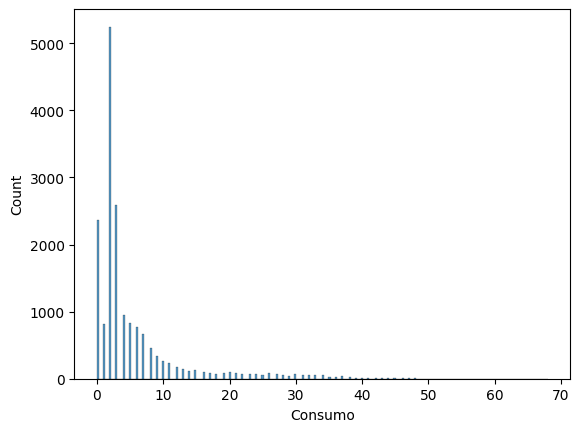

In [22]:
sns.histplot(data_reindexed, x="Consumo")

<Axes: xlabel='Consumo'>

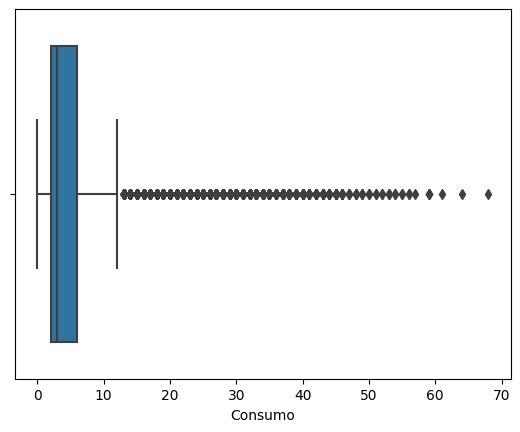

In [23]:
sns.boxplot(data_reindexed, x="Consumo" )

### Interpolación NaN´s  

antes de hacer la interpolación, quiero entender como están distribuidos esos NaN´s a lo largo del DF.

In [24]:
def consecutive_nans(series):
    # Crear una serie booleana que es True donde la serie original es NaN
    is_nan = series.isna()

    # Identificar grupos de NaNs consecutivos
    nan_groups = ((is_nan.shift() != is_nan).cumsum()).where(is_nan, np.nan)

    # Contar el tamaño de cada grupo
    group_sizes = nan_groups.value_counts()#.sort_index()

    # Imprimir la lista de tamaños de grupos
    return group_sizes.tolist()


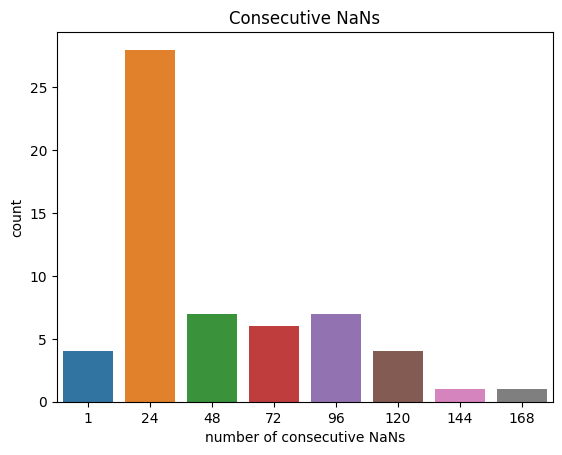

In [25]:
list_consecutive_nans = consecutive_nans(data_reindexed['Consumo'])
list_consecutive_nans

count = pd.Series(list_consecutive_nans).value_counts()
    
ax = sns.barplot(x=count.index, y=count.values)
ax.set_title('Consecutive NaNs')
ax.set_xlabel('number of consecutive NaNs')
ax.set_ylabel('count')

plt.show()

Veo que en general, huecos (como filas de NaN´s consecutivos) se agurpan en bloques de 24. Dado los datos vienen en frecuencia horaria, 24 NaN´s seguidos corresponden a 1 día, y 168 a 7 días. 

Tenía intención de hacer una función que haga interpolación **SOLO** de los bloques de NaN´s cortos, como para no afectar demasiado la función objetivo.
Puede hacerse interpolación de los pocos huecos de 1 hora, y el siguiente treshold sería ya de interpolar 24 horas... interpolaré hasta los bloques de 24 horas.

In [26]:
def interpolate_with_threshold(df, column, threshold):
    # Create a mask of NaNs
    mask = df[column].isna()

    # Identify groups of consecutive NaNs
    mask_diff = mask.diff().fillna(False)
    groups = mask_diff.cumsum()[mask]

    # Count the size of each group
    group_counts = groups.map(groups.value_counts())

    # Create a mask for groups that are less than or equal to the threshold
    interpolate_mask = group_counts <= threshold

    # Interpolate only where the mask is True
    df[column] = df[column].mask(mask).interpolate().where(interpolate_mask, df[column])

    # Count and print the number of interpolated and not interpolated values
    interpolated_count = interpolate_mask.sum()
    not_interpolated_count = mask.sum() - interpolated_count

    print(f"Interpolated count: {interpolated_count}")
    print(f"Not interpolated count: {not_interpolated_count}")

In [27]:
interpolate_with_threshold(data_reindexed, 'Consumo', 24)

Interpolated count: 676
Not interpolated count: 2232


C:\Users\afernandez\AppData\Local\Temp\ipykernel_28400\2588710448.py:6: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [28]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico (con (algunos) huecos reindexados) Casal La Monserratina - Años 2022, 2023 y 2024", "Consumo [kW]")

## Gaficas varias de la variable Consumo

### consumo resampleado a una semana

In [29]:
# Weekly Demand Plot
whole_df_1w = df.resample('1W').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Consumo"], mode='lines'))
fig.update_layout(
    title = "Consumo Eléctrico (Resample 1 semana) - Casal La Monserratina",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### consumo mes a mes

In [30]:
import calendar
from plotly.subplots import make_subplots
def plot_monthly_Consumo(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    num_plots = len(groups)
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy()
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Consumo"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        if month == 1:
            for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
                
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Consumo (kWh)", row=row, col=col)
    fig.update_layout(
        title = {
            "text": "Monthly Energy Consumo",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Consumo (kWh)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    fig.show()

plot_monthly_Consumo(df)

## Slice Dataset
la idea es quedarse solo con la zona central, dejando fuera los picos del inicio, y los huecos del final. 

In [31]:
# Definir las fechas inicial y final
fecha_inicial = '2022-07-02 00:00:00' # 'YYYY-MM-DD HH:MM:SS'.
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
df_sliced = dataframe_slicer(data_reindexed, fecha_inicial, fecha_final)

In [32]:

grafico_zoom(df_sliced["Date"], df_sliced["Consumo"],
              "Consumo Eléctrico (CON HUECOS) Casal La Monserratina - de Julio 2022 a Dic 2023 ", "Consumo [kW]")

### Outliers del df_sliced

In [33]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



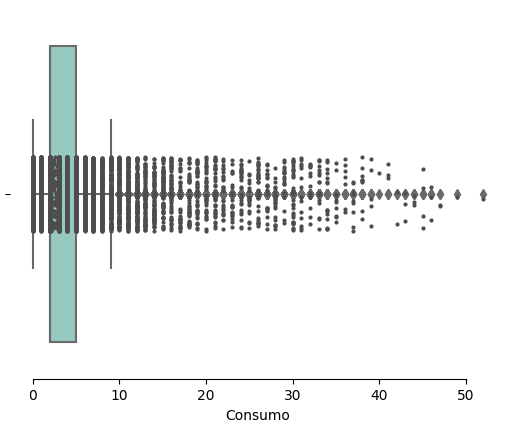

In [34]:
sns.boxplot(df_sliced, x="Consumo", width=0.8, palette="Set3")
# Add in points to show each observation
sns.stripplot(df_sliced, x="Consumo", size=3, color=".3")
sns.despine(trim=True, left=True)

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo', ylabel='Count'>

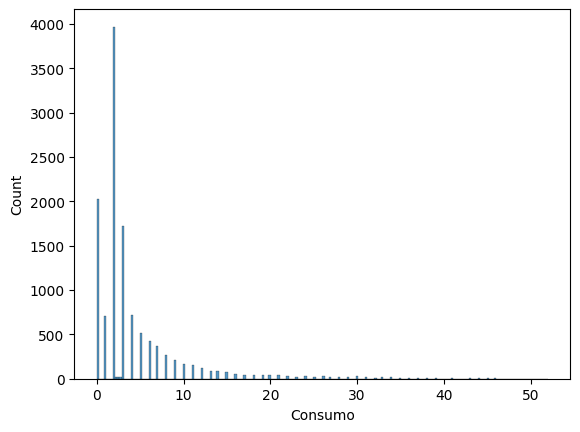

In [35]:
sns.histplot(df_sliced, x="Consumo")

## Smoothing w/moving average

In [36]:
from statsmodels.robust.scale import mad

# Define the window size for the rolling mean
window_size = 3 # datos horarios, es decir, que el window_size esta en horas.


# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
#df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()
#df_sliced['Consumo_smooth_MAD'] = df_sliced['Consumo'].rolling(window=window_size).apply(mad)

C:\Users\afernandez\AppData\Local\Temp\ipykernel_28400\2023304538.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
# Create traces for original and smoothed data
trace_original = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo'], mode='lines', name='Original')
trace_smoothed_mean = go.Scatter(x=df_sliced["Date"], y=df_sliced['Consumo_smooth_mean'], mode='lines', name='Smoothed Mean')

# Create layout
layout = go.Layout(title='Original vs Smoothed Data', xaxis=dict(title='Date'), yaxis=dict(title='Consumption [kW]'))

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean], layout=layout)

# Show figure
fig.show()

el rooling average lo que hace es calcular una media variable de la ventana definida. en este caso son bloques horarios, ej: window_size=3 hace un promedio de las ultimas 3 horas (aun no se ha aplicado upsampling a 15 min). Si bien no es la mejor idea utilizar una variable modificada como funcion objetivo, pareciera que la curva resultante tiene mucho menos ruido y copia casi perfectamente la curva original.

### Outliers del smoothed DF

In [38]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean
count                12408  12288.000000         12282.000000
mean   2023-03-17 11:30:00      4.222168             4.223036
min    2022-07-02 00:00:00      0.000000             0.000000
25%    2022-11-08 05:45:00      2.000000             2.000000
50%    2023-03-17 11:30:00      2.000000             2.333333
75%    2023-07-24 17:15:00      5.000000             4.666667
max    2023-11-30 23:00:00     52.000000            47.666667
std                    NaN      5.769920             5.224750

In [39]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1306. Sus limites son -2.5 y 9.5.

For Consumo_smooth_mean Column, the Number of Outliers is 1370. Sus limites son -2.0 y 8.666666666666668.



<Axes: xlabel='Consumo_smooth_mean'>

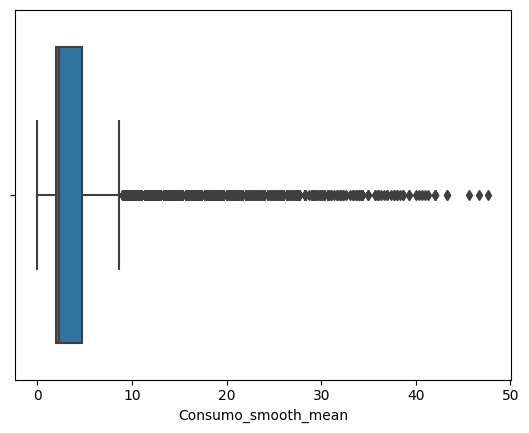

In [40]:
sns.boxplot(df_sliced, x="Consumo_smooth_mean")

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo_smooth_mean', ylabel='Count'>

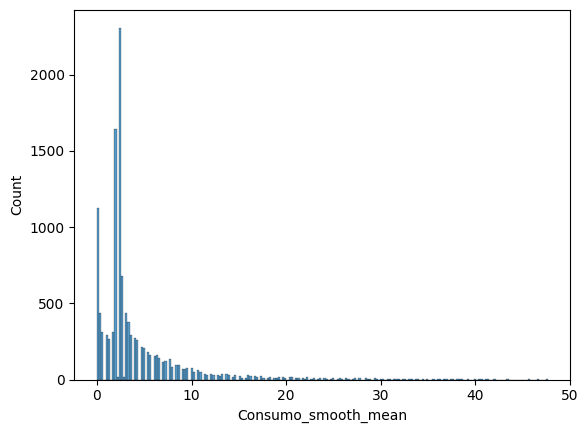

In [41]:
sns.histplot(df_sliced, x="Consumo_smooth_mean")

# upsampling a 15 min

In [42]:
df_upsampled = df_sliced.copy()

In [43]:
df_upsampled.set_index("Date", inplace=True)

In [44]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean
Date                                             
2022-07-02 00:00:00     3.00                  NaN
2022-07-02 00:15:00     2.75                  NaN
2022-07-02 00:30:00     2.50                  NaN
2022-07-02 00:45:00     2.25                  NaN
2022-07-02 01:00:00     2.00                  NaN
...                      ...                  ...
2023-11-30 22:00:00     2.00             3.666667
2023-11-30 22:15:00     2.00             3.416667
2023-11-30 22:30:00     2.00             3.166667
2023-11-30 22:45:00     2.00             2.916667
2023-11-30 23:00:00     2.00             2.666667

[49629 rows x 2 columns]

# Merge Consumo con PPV

In [91]:
# Load the DataFrame with the PV & weather data

nombre_archivo = "LaMonserratina_weather_&_PV.csv"

df_PV = pd.read_csv(os.path.join(ruta_data, nombre_archivo))

df_PV.rename(columns={"timestamp_local": "Date"}, inplace=True)
df_PV.drop(columns=["Unnamed: 0"], inplace=True)
#df_PV.set_index("Date", inplace=True)


In [92]:
# Rename para quitar espacios y [] de los nombres de las columnas
df_PV.rename(columns={
       'pres [mb]':'pres_mb', 
       'slp [mb]':"slp_mb", 
       'wind_dir [m/s]':'wind_dir_m/s',
       'wind_gust_spd [m/s]':'wind_gust_spd_m/s', 
       'wind_spd [m/s]':'wind_spd_m/s', 
       'temp [C]':'temp_C', 
       'app_temp [C]':'app_temp_C', 
       'rh [%]':'rh_%', 
       'dewpt [C]':'dewpt_C', 
       'clouds [%]':'clouds_%', 
       'precip [mm]':'precip_mm', 
       'dhi [W/m^2]':'dhi_W/m2', 
       'dni [W/m^2]':'dni_W/m2', 
       'ghi [W/m^2]':'ghi_W/m2', 
       'solar_rad [W/m^2]':'solar_rad_W/m2',
       'uv [0-11+]':'uv_0-11', 
       'elev_angle [º]':'elev_angle_º', 
       'azimuth [º]':'azimuth_º',
       'Temp interna Modulo [C]':'Temp interna Modulo_C', 
       "PV [Wh]" : "PV_Wh"
       }, inplace=True)

In [93]:
df_PV.head(3)

Date  pres_mb  slp_mb  wind_dir_m/s  wind_gust_spd_m/s  \
0  2022-01-01 00:00:00   1027.0  1028.0         360.0                4.0   
1  2022-01-01 00:15:00   1027.0  1028.0         357.5                4.1   
2  2022-01-01 00:30:00   1027.0  1028.0         355.0                4.2   

   wind_spd_m/s  temp_C  app_temp_C   rh_%  dewpt_C  ...  precip_mm  dhi_W/m2  \
0         1.775    10.7        10.7  88.25    9.500  ...        0.0       0.0   
1         1.775    10.7        10.7  88.25    9.325  ...        0.0       0.0   
2         1.800    10.7        10.7  88.25    9.150  ...        0.0       0.0   

   dni_W/m2  ghi_W/m2  solar_rad_W/m2  uv_0-11  elev_angle_º  azimuth_º  \
0       0.0       0.0             0.0      0.0        -48.35    323.400   
1       0.0       0.0             0.0      0.0        -48.35    243.575   
2       0.0       0.0             0.0      0.0        -48.35    163.650   

   Temp interna Modulo_C  PV_Wh  
0              22.066196    0.0  
1              22.066196    0.0  
2              22.066196    0.0  

[3 rows x 21 columns]

In [94]:
checkNaNValues(df_PV)
missing_dates, date_range = checkMissingData(df_PV, 'Date')

NaN Count per Column 0
Number of Missing Values: 0


C:\Users\afernandez\AppData\Local\Temp\ipykernel_28400\1343014103.py:7: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



In [98]:
#df3.set_index("Date", inplace=True)

df_upsampled.rename(columns={"Consumo": "Consumo_kW"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_mean": "Consumo_smooth_mean_kW"}, inplace=True)

# df_upsampled.reset_index(inplace=True)
# df_upsampled.drop(columns=["index"], inplace=True)


df_upsampled.head(3)

Date  Consumo_kW  Consumo_smooth_mean_kW
0 2022-07-02 00:00:00        3.00                     NaN
1 2022-07-02 00:15:00        2.75                     NaN
2 2022-07-02 00:30:00        2.50                     NaN

In [99]:
df_upsampled['Date'] = pd.to_datetime(df_upsampled['Date'])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])

In [101]:
df4 = df_upsampled.merge(df_PV, how="inner", on="Date")
df4.sample(2)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
45903 2023-10-23 03:45:00        2.75                    2.25  1007.75   
41525 2023-09-07 13:15:00        2.43                    2.47  1018.00   

        slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
45903  1008.00         70.00               11.5        8.1900  20.075   
41525  1018.75        118.75                4.5        3.9675  25.450   

       app_temp_C  ...  precip_mm  dhi_W/m2  dni_W/m2  ghi_W/m2  \
45903       20.15  ...        0.0      0.00       0.0       0.0   
41525       25.85  ...        0.0    116.25     894.5     825.0   

       solar_rad_W/m2  uv_0-11  elev_angle_º  azimuth_º  \
45903            0.00      0.0        -48.35     52.175   
41525          775.75      5.6         53.20    165.600   

       Temp interna Modulo_C         PV_Wh  
45903              26.300958  0.000000e+00  
41525              49.039406  4.506174e+06  

[2 rows x 23 columns]

hay un probma con las unidades, Consumo de Red esta en kW, y PV en W.. ajusto PV/1000. y agrego las unidades a los nombres para evitar confusiones

In [102]:
df4["PV_Wh"] = (df4["PV_Wh"]/1000000).round(3)
df4.sample(5)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
35448 2023-07-06 06:00:00         4.0                3.000000  1015.00   
18967 2023-01-15 13:45:00         0.0                0.166667  1015.25   
16657 2022-12-22 12:15:00         1.0                2.916667  1022.75   
28518 2023-04-25 01:30:00         2.0                2.000000  1014.50   
18090 2023-01-06 10:30:00         0.5                1.000000  1025.00   

        slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
35448  1016.00         360.0                4.8        4.0900  22.200   
18967  1015.25         120.0                4.3        2.7000  16.500   
16657  1023.00         272.5                6.6        3.7175  15.125   
28518  1015.00          90.0                4.0        2.8500  16.100   
18090  1025.50         360.0                5.0        4.8400   8.700   

       app_temp_C  ...  precip_mm  dhi_W/m2  dni_W/m2  ghi_W/m2  \
35448      22.700  ...        0.0      0.00      0.00      0.00   
18967      16.500  ...        0.0     91.75    773.75    429.75   
16657      15.125  ...        0.0     88.50    752.75    393.50   
28518      16.100  ...        0.0      0.00      0.00      0.00   
18090       8.700  ...        0.0     74.00    648.50    262.50   

       solar_rad_W/m2  uv_0-11  elev_angle_º  azimuth_º  \
35448             0.0     0.00        -4.800     54.000   
18967           427.5     2.05        26.375    191.425   
16657           393.5     1.55        24.450    171.075   
28518             0.0     0.00       -34.850    174.200   
18090           261.5     1.30        17.350    144.700   

       Temp interna Modulo_C  PV_Wh  
35448              27.260838  0.000  
18967              42.254869  4.144  
16657              41.156945  4.071  
28518              24.505419  0.000  
18090              35.526254  3.679  

[5 rows x 23 columns]

## add some extra exogenous variables columns

In [103]:
df5 = df4.copy()
df5.sample(1)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
35032 2023-07-01 22:00:00         2.0                    19.0   1014.0   

       slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
35032  1014.0         250.0                6.8          5.09    24.2   

       app_temp_C  ...  precip_mm  dhi_W/m2  dni_W/m2  ghi_W/m2  \
35032        24.4  ...        0.0       0.0       0.0       0.0   

       solar_rad_W/m2  uv_0-11  elev_angle_º  azimuth_º  \
35032             0.0      0.0          -5.7      307.6   

       Temp interna Modulo_C  PV_Wh  
35032              28.164254    0.0  

[1 rows x 23 columns]

In [105]:
df5["Year"] = df5["Date"].dt.year
df5["Month"] = df5["Date"].dt.month
df5["Hour"] = df5["Date"].dt.hour
df5["DayOfWeek"] = df5["Date"].dt.day_of_week
df5["DayOfYear"] = df5["Date"].dt.day_of_year
df5["Day"] = df5["Date"].dt.day
df5["Minute"] = df5["Date"].dt.minute

In [106]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [107]:
#Add Demand 7 days before Column
df5["Consumo_kW_-7d"] = df5["Consumo_kW"].shift(7 * 96).fillna(0)

#Add isWeekend Column based in DayOfTheWeek Value
df5["isWeekend"] = df5["DayOfWeek"].isin([5, 6])

# #Generate Sin and Cos Transformations
# df5 = generateSinCosHour(df5)

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df5 = cyclical_encoding(df5, cycle_lengths, cols)

df5.sample(5)

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  \
5756  2022-08-30 23:00:00        2.00                2.000000  1015.00   
27073 2023-04-10 00:15:00        2.25                2.083333  1021.00   
33020 2023-06-10 23:00:00        2.00                8.333333  1013.00   
8682  2022-09-30 10:30:00        0.50                2.166667  1009.00   
24879 2023-03-18 03:45:00        2.00                2.000000  1012.25   

       slp_mb  wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  \
5756   1016.0        260.00              5.200         4.090  27.600   
27073  1021.0        271.25              3.100         1.975  13.575   
33020  1014.0        210.00              3.100         1.775  22.700   
8682   1009.5        355.00              8.095         5.395  17.300   
24879  1013.0        262.50              4.300         2.225  12.025   

       app_temp_C  ...  Consumo_kW_-7d  isWeekend  Hour_sin  Hour_cos  \
5756       30.875  ...            2.00      False   -0.5000    0.8660   
27073      13.575  ...            2.25      False   -0.2588    0.9659   
33020      23.200  ...            3.00       True   -0.5000    0.8660   
8682       17.300  ...            0.50      False    0.7071   -0.7071   
24879      12.025  ...            2.75       True    0.5000    0.8660   

       DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  \
5756          0.0000         1.0000     -0.500     -0.866        -0.8452   
27073        -0.7818         0.6235      1.000      0.000         0.9911   
33020        -0.4339        -0.9010      0.500     -0.866         0.3777   
8682          0.4339        -0.9010     -0.866     -0.500        -0.9995   
24879        -0.4339        -0.9010      0.866      0.500         0.9657   

       DayOfYear_cos  
5756         -0.5344  
27073        -0.1330  
33020        -0.9259  
8682         -0.0301  
24879         0.2595  

[5 rows x 40 columns]

In [109]:
#Add Demand 7 days before Column
df5["Consumo_kW	-24h"] = df5["Consumo_kW"].shift(96).fillna(0)

In [ ]:
# #Add Demand 24 hours before Column 
# def getDayBeforeDemand(df, row):
#     date = row["Date"]
#     counter, demand_24h = 0, 0
#     if row.isWeekend:
#         while counter < 7:
#             date -= timedelta(days=1)
#             row_24h = df.loc[df["Date"] == date]
#             if not row_24h.empty:
#                 row_24h = row_24h.iloc[[0]].squeeze()
#                 if row_24h["isWeekend"]:
#                     demand_24h = row_24h["Consumo_total [kW]"]
#                     break
#             counter += 1
#     else:
#         while counter < 7:
#             date -= timedelta(days=1)
#             row_24h = df.loc[df["Date"] == date]
#             if not row_24h.empty:
#                 row_24h = row_24h.iloc[[0]].squeeze()
#                 if row_24h["isWeekend"]:
#                     demand_24h = row_24h["Consumo_total [kW]"]
#                     break
#             counter += 1
#     return demand_24h

# df5["Demand_24h"] = df5.apply(
#     lambda row: getDayBeforeDemand(df5, row), axis=1)

In [110]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df5 = generateHolidayVar(df5)
display(df5[["Date", "isHoliday"]].sample(5))

Date  isHoliday
10513 2022-10-19 12:15:00      False
41957 2023-09-12 01:15:00      False
35480 2023-07-06 14:00:00      False
40674 2023-08-29 16:30:00      False
23204 2023-02-28 17:00:00      False

# Plots

## Demand Distribution Plots

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='Consumo_kW', ylabel='Count'>

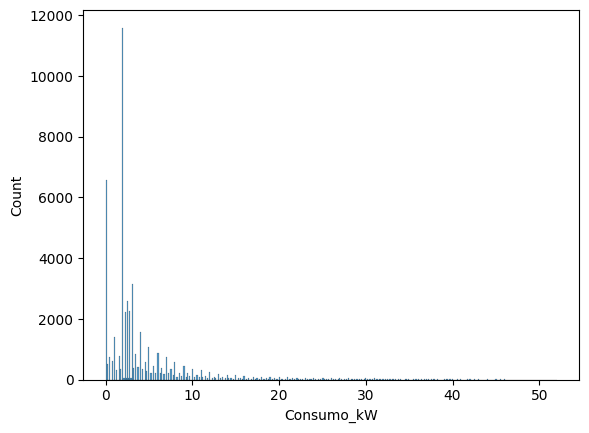

In [113]:
sns.histplot(df5["Consumo_kW"])

Text(0.5, 0.98, '')

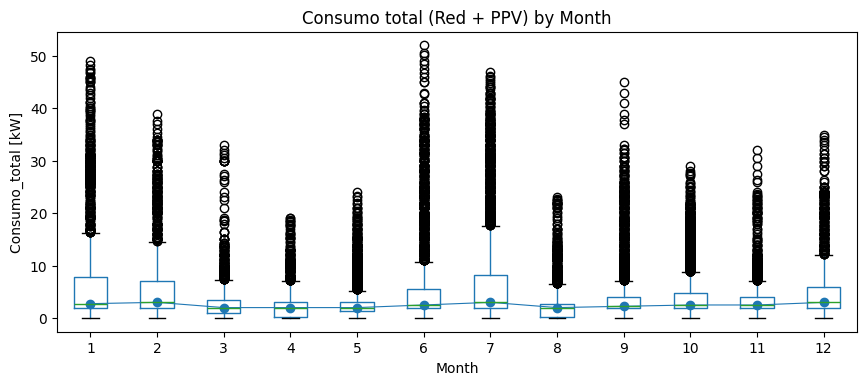

In [116]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Month', ax=ax)
df5.groupby('Month')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo_total [kW]')
ax.set_title("Consumo total (Red + PPV) by Month")
fig.suptitle('')

## Consumo total por día

Text(0.5, 0.98, '')

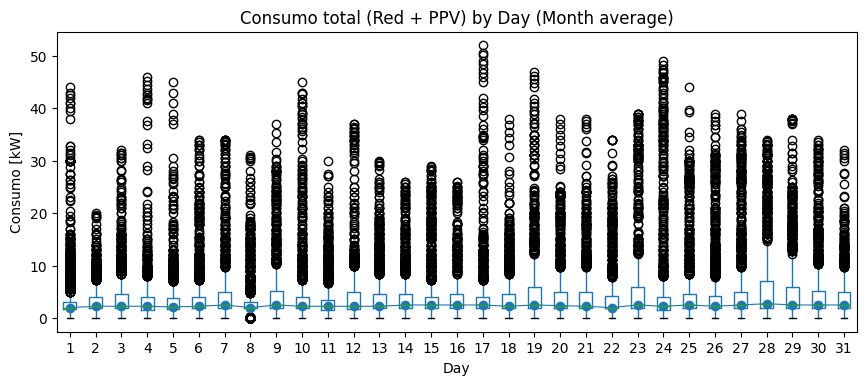

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Day', ax=ax)
df5.groupby('Day')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kW]')
ax.set_title("Consumo total (Red + PPV) by Day (Month average)")
fig.suptitle('')

Text(0.5, 0.98, '')

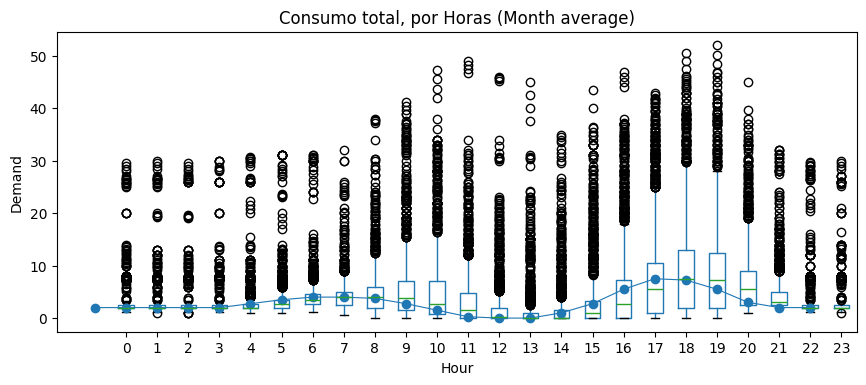

In [120]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Hour', ax=ax)
df5.groupby('Hour')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title("Consumo total, por Horas (Month average)")
fig.suptitle('')

## Demand per Day and Season

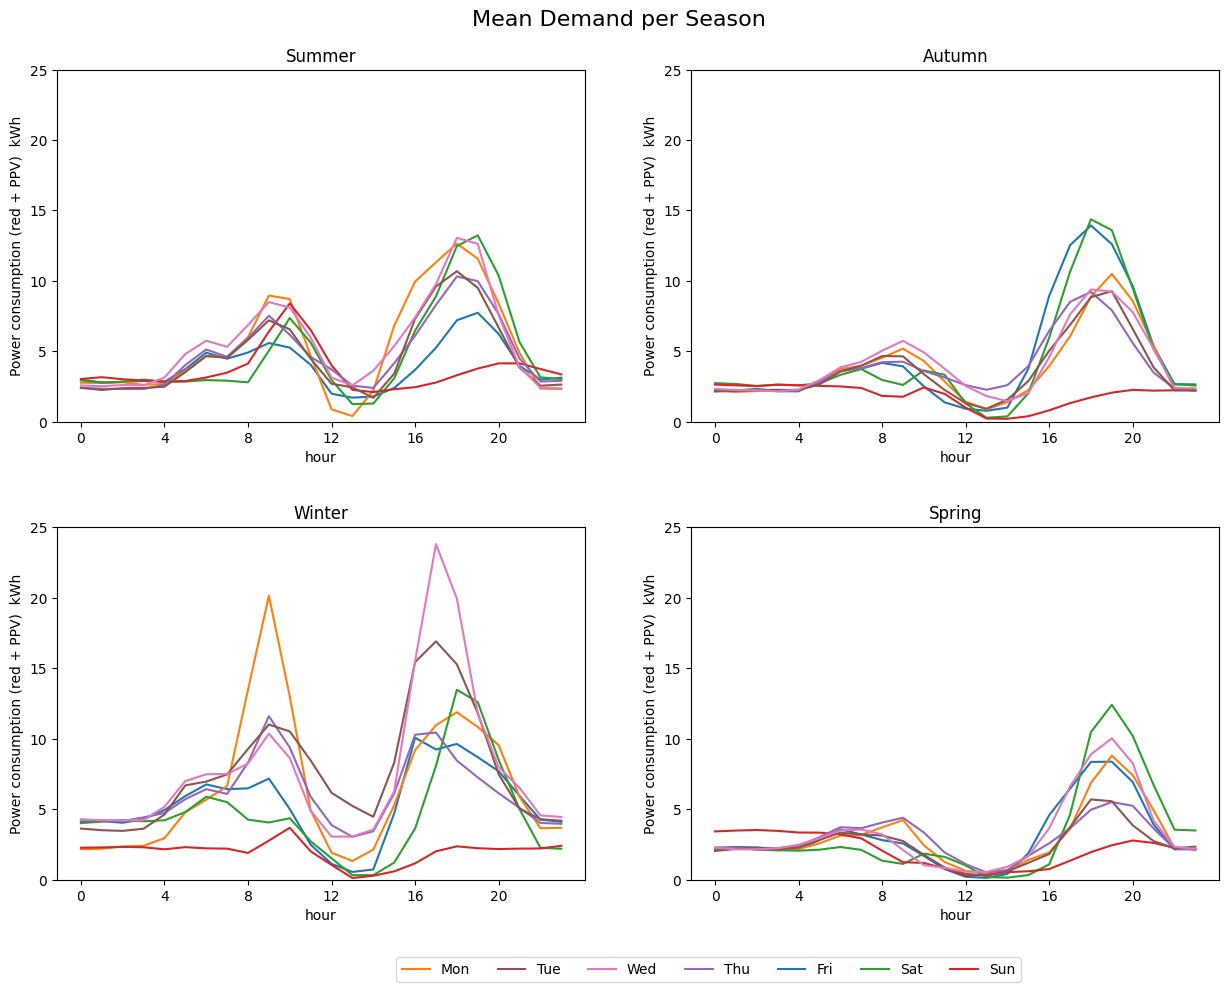

In [122]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df5["Day"] = df5["DayOfWeek"].map(days_mapping)
df5["Season"] = df5["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Mean Demand per Season", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df5.loc[df5["Season"] == 2] \
    .groupby([df5.loc[df5["Season"] == 2]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
df5.loc[df5["Season"] == 3] \
    .groupby([df5.loc[df5["Season"] == 3]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
df5.loc[df5["Season"] == 0] \
    .groupby([df5.loc[df5["Season"] == 0]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
df5.loc[df5["Season"] == 1] \
    .groupby([df5.loc[df5["Season"] == 1]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='hour', ylabel='Power consumption (red + PPV)  kWh')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df5 = df5.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

## Temperature Distribution by Hour

Text(0.5, 0.98, '')

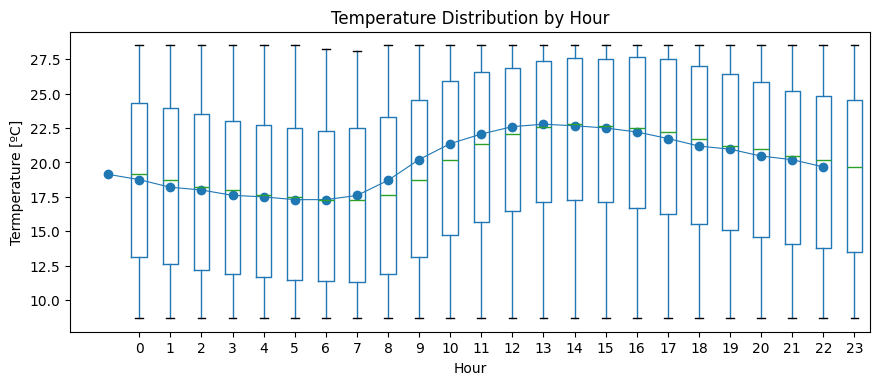

In [124]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='temp_C', by='Hour', ax=ax)
df5.groupby('Hour')['temp_C'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperature Distribution by Hour")
fig.suptitle('')

## Relacion entre Demanda Energética y Temperatura. 

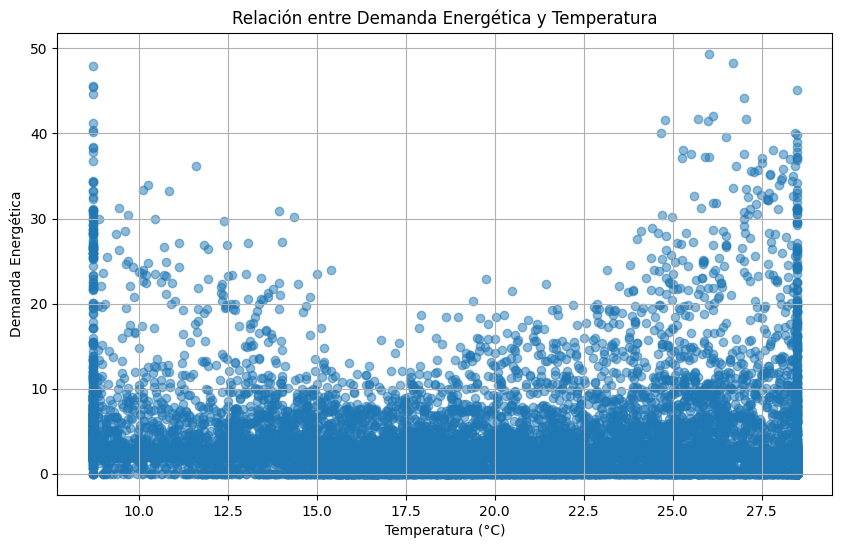

In [126]:
def plot_temp_vs_demand(df):
    df = df.copy()
    df.set_index("Date", inplace=True)
    df_1h = df.resample('1h').mean()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_1h['temp_C'], df_1h['Consumo_kW'], alpha=0.5)
    plt.title('Relación entre Demanda Energética y Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Demanda Energética')
    plt.grid(True)
    plt.show()
plot_temp_vs_demand(df5)

Si hubiese buena correlacion entre demanda y temperatura, los puntos deberían formar una especie de "U", ya que cuanto mayor o menor sea la temperatura, mayor será el consumo energético para mejorar el confort. 

Por otro lado, los bordes rectos se deben a la windsorización de la temperatura en el prepfocessing. 

## Irradiacion Solar (Mensual)

Text(0.5, 0.98, '')

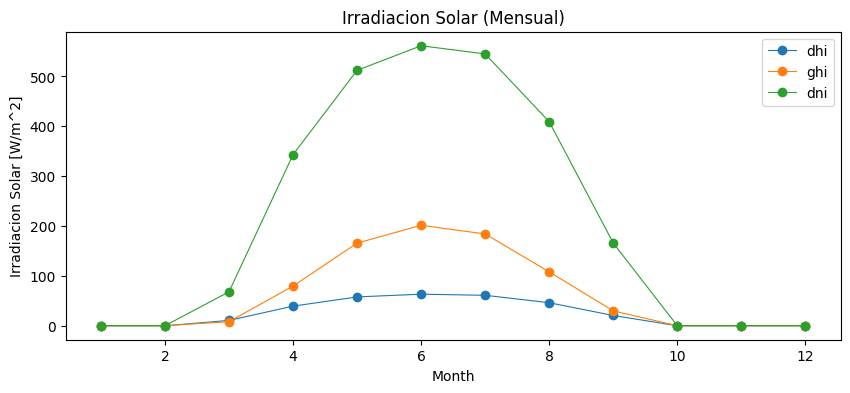

In [132]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar (Mensual)")
fig.suptitle('')

## Irradiacion Solar (Horaria)

Text(0.5, 0.98, '')

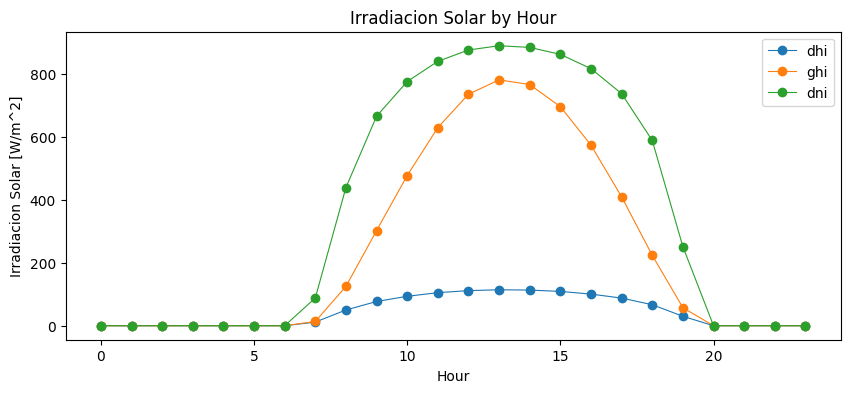

In [134]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar by Hour")
fig.suptitle('')

## AutoCorrelation Plots

In [143]:
df5.head()

Date  Consumo_kW  Consumo_smooth_mean_kW  pres_mb  slp_mb  \
0 2022-07-02 00:00:00        3.00                     NaN   1019.0  1020.0   
1 2022-07-02 00:15:00        2.75                     NaN   1019.0  1020.0   
2 2022-07-02 00:30:00        2.50                     NaN   1019.0  1020.0   
3 2022-07-02 00:45:00        2.25                     NaN   1019.0  1020.0   
4 2022-07-02 01:00:00        2.00                     NaN   1019.0  1020.0   

   wind_dir_m/s  wind_gust_spd_m/s  wind_spd_m/s  temp_C  app_temp_C  ...  \
0         150.0                3.1         1.775  23.100      23.000  ...   
1         192.5                3.1         1.775  22.825      22.725  ...   
2         235.0                3.1         1.775  22.550      22.450  ...   
3         277.5                3.1         1.775  22.275      22.175  ...   
4         320.0                3.1         1.775  22.000      21.900  ...   

   Hour_cos  DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  \
0    0.9659        -0.4339         -0.901        0.0       -1.0   
1    0.9659        -0.4339         -0.901        0.0       -1.0   
2    0.9659        -0.4339         -0.901        0.0       -1.0   
3    0.9659        -0.4339         -0.901        0.0       -1.0   
4    1.0000        -0.4339         -0.901        0.0       -1.0   

   DayOfYear_sin  DayOfYear_cos  Consumo_kW\t-24h  isHoliday  Season  
0         0.0086           -1.0               0.0      False       2  
1         0.0086           -1.0               0.0      False       2  
2         0.0086           -1.0               0.0      False       2  
3         0.0086           -1.0               0.0      False       2  
4         0.0086           -1.0               0.0      False       2  

[5 rows x 42 columns]

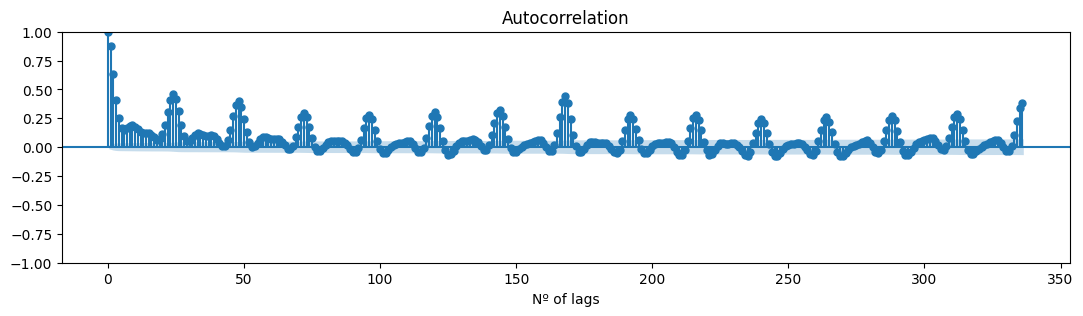

In [144]:
from statsmodels.graphics.tsaplots import plot_acf

#Gráfico de autocorrelación 1
def corrPlot(df):
    df = df.copy()
    df.set_index("Date", inplace=True)
    demand_df_1h = df["Consumo_kW"].resample('1h').mean()
    fig, ax = plt.subplots(figsize=(13, 3))
    plt.xlabel("Nº of lags")
    plot_acf(demand_df_1h, ax=ax, lags=24*14)
    plt.show()

corrPlot(df5)

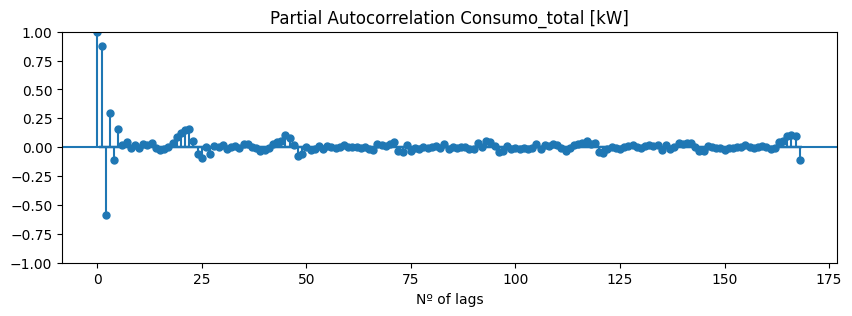

In [146]:
from statsmodels.graphics.tsaplots import plot_pacf
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(dfAutocorr["Consumo_kW"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation Consumo_total [kW]")
plt.show()

## Correlation Matrix

In [147]:
df5.columns

Index(['Date', 'Consumo_kW', 'Consumo_smooth_mean_kW', 'pres_mb', 'slp_mb',
       'wind_dir_m/s', 'wind_gust_spd_m/s', 'wind_spd_m/s', 'temp_C',
       'app_temp_C', 'rh_%', 'dewpt_C', 'clouds_%', 'precip_mm', 'dhi_W/m2',
       'dni_W/m2', 'ghi_W/m2', 'solar_rad_W/m2', 'uv_0-11', 'elev_angle_º',
       'azimuth_º', 'Temp interna Modulo_C', 'PV_Wh', 'Year', 'Month', 'Hour',
       'DayOfWeek', 'DayOfYear', 'Minute', 'Consumo_kW_-7d', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'Consumo_kW\t-24h',
       'isHoliday', 'Season'],
      dtype='object')

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:80: UserWarning:

Glyph 9 (	) missing from current font.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning:

Glyph 9 (	) missing from current font.

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



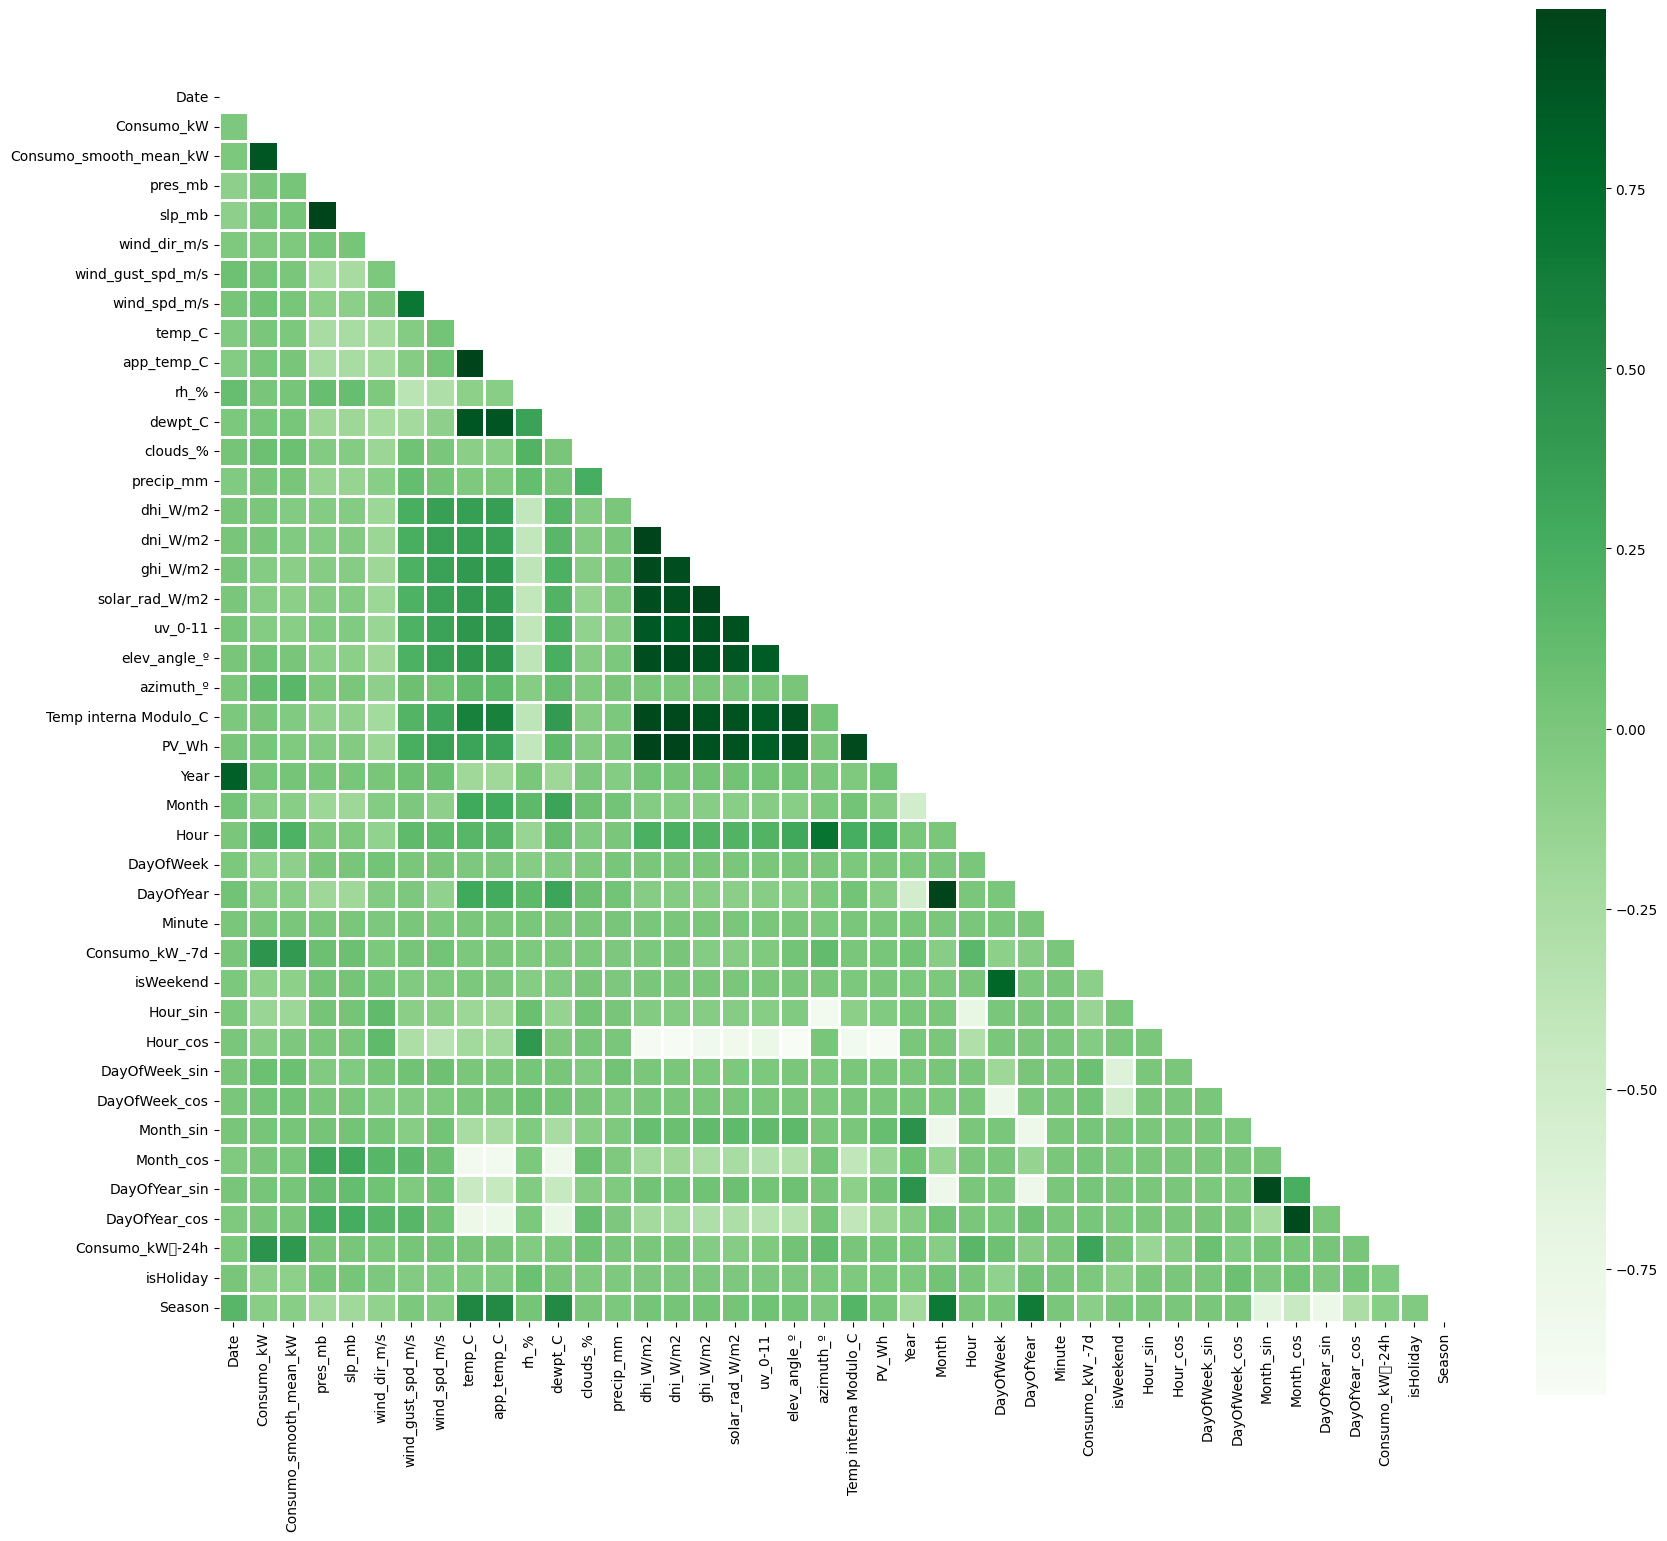

In [148]:
# Calcula la matriz de correlación completa
correlation_matrix = df5.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



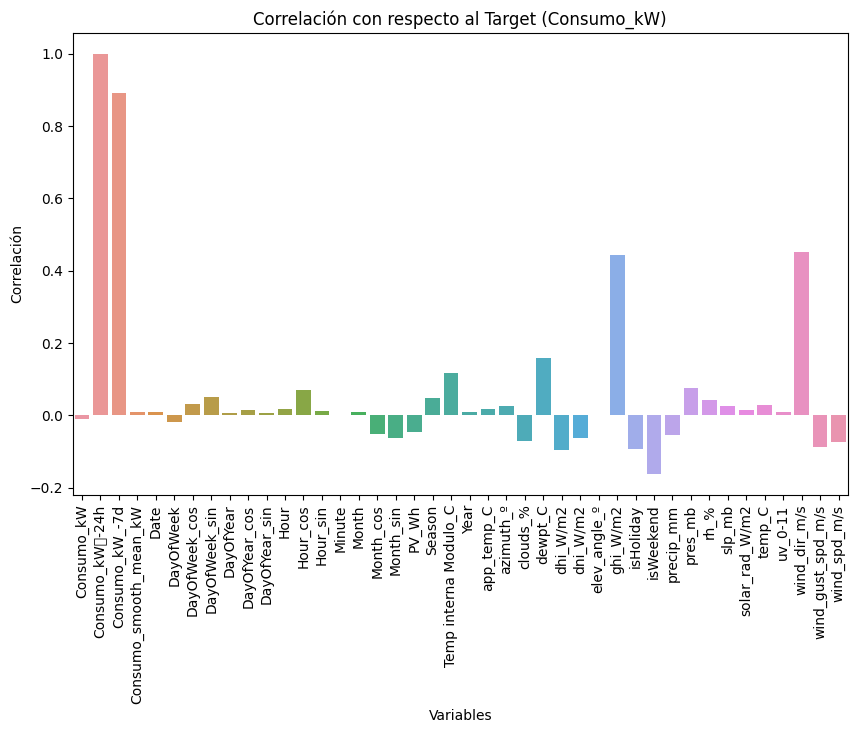

In [156]:
# Crear un gráfico de barras de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.index, y=correlation_matrix['Consumo_kW'])
plt.title('Correlación con respecto al Target (Consumo_kW)')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

## Time series decpomposition

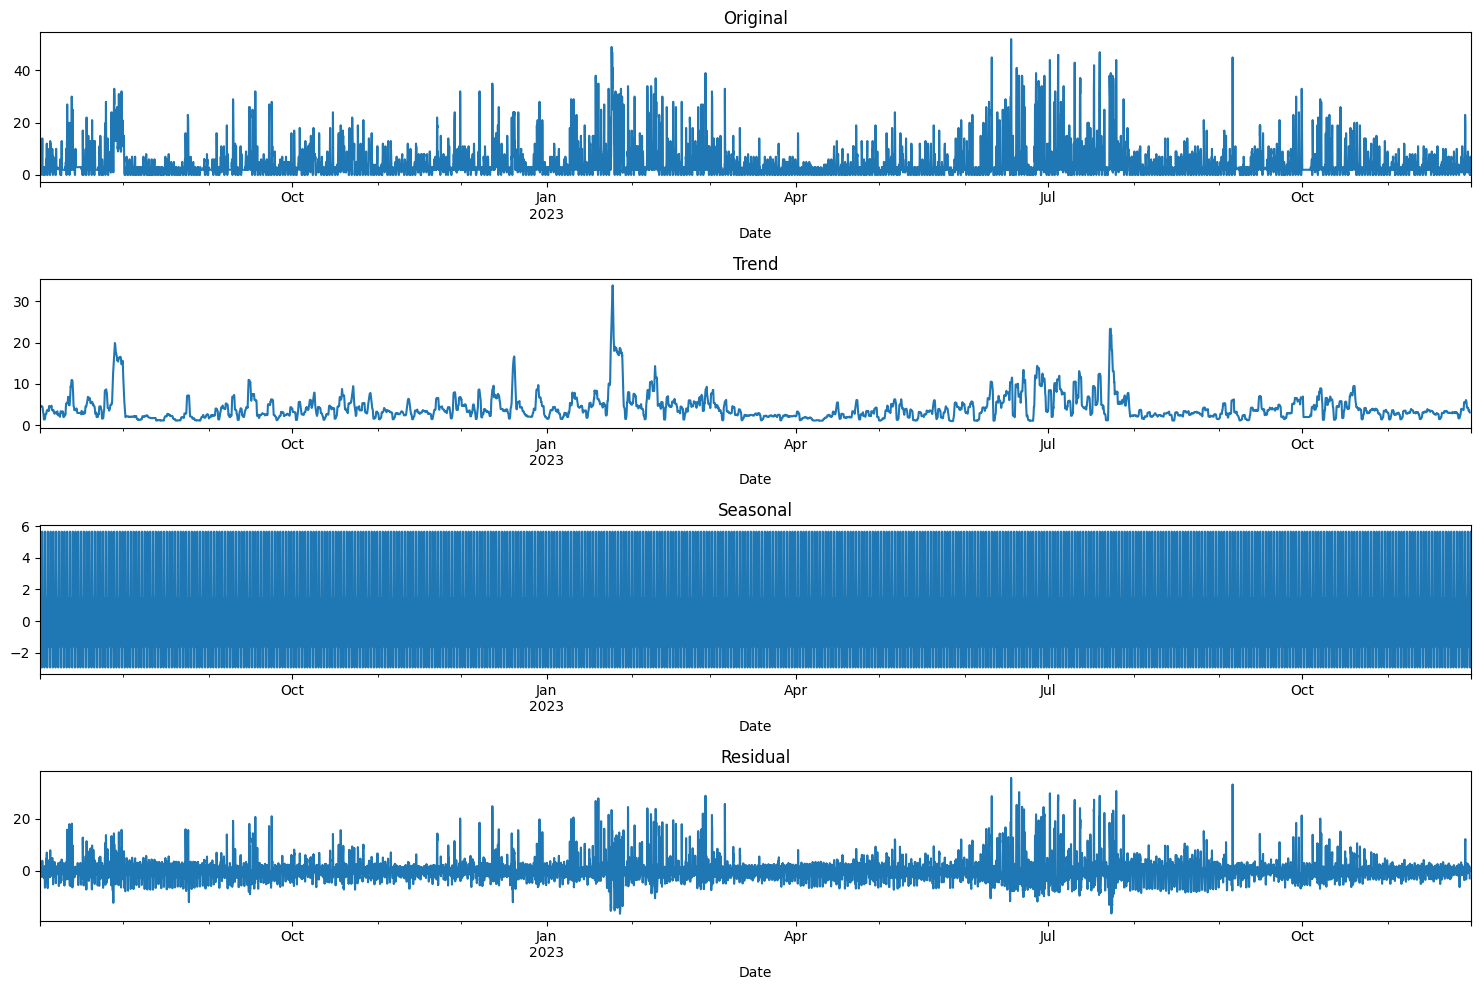

In [167]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df


decomposed_df = decompose_time_series(df5, "Consumo_kW", 96)

decomposed_df.set_index('Date', inplace=True)

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo_kW"].plot(ax=axes[0], title="Original")
decomposed_df["Consumo_kW_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_kW_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_kW_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()

# SAVE csv

In [168]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_CLEAN_2022_2023_2024.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df5.to_csv(ruta_completa, index=False)